# Retail Data Wrangling and Analytics

In [1]:
# Import modules 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Load Data from PSQL into DataFrame

**Setup Docker Containers**

![](https://i.imgur.com/VQrBVBk.jpeg)

```
# Start both existing containers
# (These were previously created as jrvs-jupyter and jrvs-psql)
docker start jrvs-jupyter
docker start jrvs-psql

# Create a dedicated bridge network so the containers can communicate
docker network create jarvis-net

# Attach both running containers to the shared network
docker network connect jarvis-net jrvs-jupyter
docker network connect jarvis-net jrvs-psql

# Verify that both containers are now part of the jarvis-net network
docker network inspect jarvis-net

```

**Data Preparation**

- Used [pandas.read_sql](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql.html) api to load the PSQL retail table into a Pandas DataFrame


In [2]:
#install psql "driver"
!pip3 install psycopg2-binary

In [3]:
import psycopg2 as pg 

In [4]:
engine_string = "dbname=postgres user=postgres password=password host=jrvs-psql port=5432"
engine = pg.connect(engine_string)
retail_df = pd.read_sql("SELECT * FROM retail", engine)
retail_df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Load CSV into Dataframe
Alternatively, the LGS IT team also dumped the transactional data into a [CSV file](https://raw.githubusercontent.com/jarviscanada/jarvis_data_eng_demo/feature/data/python_data_wrangling/data/online_retail_II.csv). However, the CSV header (column names) doesn't follow the snakecase or camelcase naming convention (e.g. `Customer ID` instead of `customer_id` or `CustomerID`). As a result, Pandas is used to clean up the data before doing any analytics, and correct data types where needed. \
**Data Preparation**

- Read the `data/online_retail_II.csv` file into a DataFrame names `online_retail_df`
- Rename all columns to upper camelcase or snakecase
- Convert/cast all columns to the appropriate data types (e.g. datetime)

In [5]:
#Read the `data/online_retail_II.csv` file into a DataFrame names `online_retail_df` which is the one manipulated for analytics during this project.
online_retail_df = pd.read_csv("data/online_retail_II.csv")

online_retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [6]:
online_retail_df.columns = (online_retail_df.columns
                            .str.replace(" ", "")
                           )
online_retail_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Total Invoice Amount Distribution

In [7]:
#convert invoice Date to the appropriate data type
online_retail_df['InvoiceDate'] = pd.to_datetime(online_retail_df['InvoiceDate'])
                     
online_retail_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [8]:
#dataframe with invoice amount and invoice number 
invoice_amount_df = (
    online_retail_df
    .assign(Amount=lambda x: x['Quantity'] * x['Price'])
    .groupby('Invoice', as_index=False)['Amount']
    .sum()
    .loc[lambda df: df['Amount']>0]
)

In [9]:
def show_distribution(column):
    """
    This function print summary statictics and plot the distribution of a numeric column
    into a histogram and a horizontal box plot to show spread and outliers.
    
    """

    min_invoice=column.min()
    max_invoice=column.max()
    mode_invoice=column.mode().iloc[0]
    mean_invoice=column.mean()
    median_invoice=column.median()
    
    
    print(f"Minimum:{min_invoice:.2f}")
    print(f"Mean:{mean_invoice:.2f}")
    print(f"Median:{median_invoice:.2f}")
    print(f"Mode:{mode_invoice:.2f}")
    print(f"Maximum:{max_invoice:.2f}\n")
    
    fig, axes = plt.subplots(2, 1 , figsize=(10,4))

    #Histogran
    axes[0].hist(column, bins=10) 
    axes[0].set_title("Data Distribution\n")
    axes[0].set_ylabel("Frequency")
    
    #Reference lines
    axes[0].axvline(min_invoice, color="grey", linestyle="--", linewidth=2)
    axes[0].axvline(mean_invoice, color="skyblue", linestyle="--", linewidth=2)
    axes[0].axvline(median_invoice, color="red", linestyle="--", linewidth=2)
    axes[0].axvline(mode_invoice, color="yellow", linestyle="--", linewidth=2)
    axes[0].axvline(max_invoice, color="gray", linestyle="--", linewidth=2)


    #Box plot
    axes[1].boxplot(column, vert=False)
    

    plt.show()


Minimum:0.19
Mean:523.30
Median:304.32
Mode:15.00
Maximum:168469.60



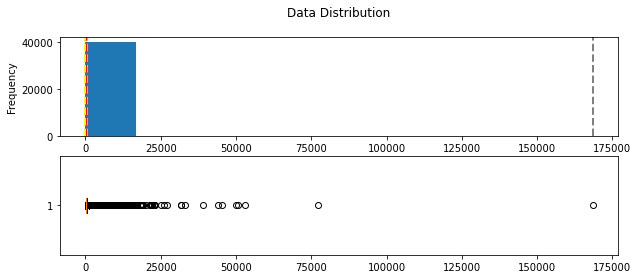

In [10]:
show_distribution(invoice_amount_df['Amount'])

# Distribution of the first 85 quantiles of the invoice amount data

Minimum:0.19
Mean:271.68
Median:256.24
Mode:15.00
Maximum:724.25



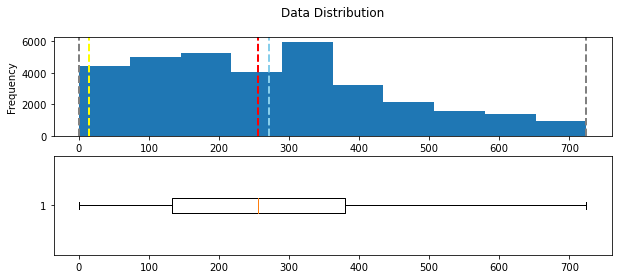

In [11]:
q85 = invoice_amount_df['Amount'].quantile(0.85)
remove_outliers = invoice_amount_df[invoice_amount_df['Amount'] <= q85]
show_distribution(remove_outliers['Amount'])

# Monthly Placed and Canceled Orders

```
Cancelled orders are identified by invoice numbers starting with 'C'. Each cancellation appears twice in the data(original invoice + cancelled invoice), and both occur on the same day/month.

Total orders = all invoices 
Canceled orders = invoices starting with 'C' 
placed orders = total orders - 2 * canceled orders

```


<AxesSubplot:xlabel='InvoiceYearMonth'>

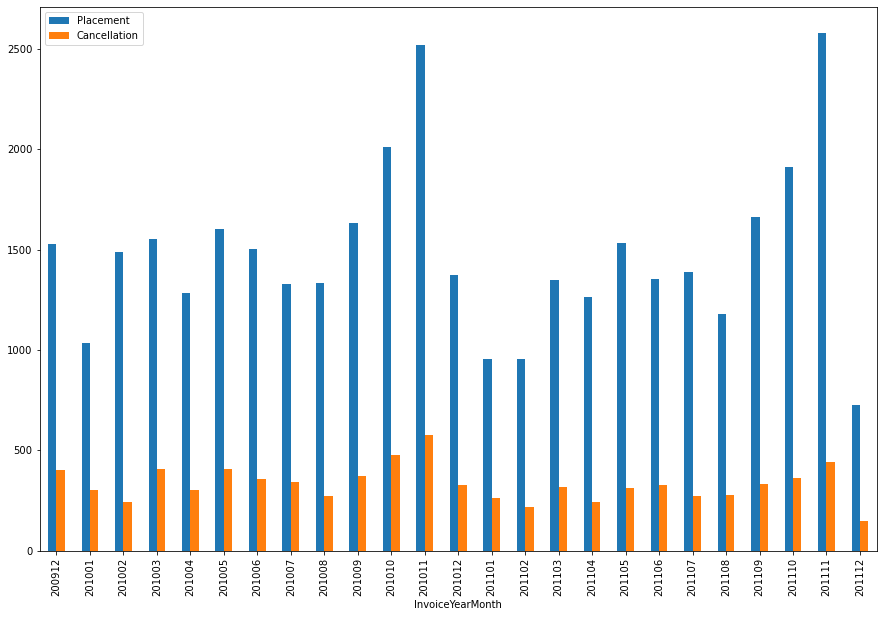

In [12]:
#new invoice date column with YYYYNNN format as integer to facilitate grouping
online_retail_df['InvoiceYearMonth']= online_retail_df['InvoiceDate'].dt.strftime('%Y%m')

#new boolean column to flag cancelled orders
online_retail_df['IsCancelled'] = online_retail_df['Invoice'].astype(str).str.startswith('C')

monthly_total_orders = (
    online_retail_df
    .groupby('InvoiceYearMonth', as_index=False)['Invoice']
    .nunique()
    .rename(columns={'Invoice': 'TotalOrders'})
)

#Canceled orders per month
monthly_canceled_orders_df = (
    online_retail_df[online_retail_df['IsCancelled']]
    .groupby('InvoiceYearMonth', as_index=False)['Invoice']
    .nunique()
    .rename(columns={'Invoice': 'Cancellation'})
)

#Compute Placement = TotalOrders - 2 * Cancellation
monthly_placed_orders_df = (
    monthly_total_orders
    .merge(monthly_canceled_orders_df, on='InvoiceYearMonth', how='left')
    .fillna({'Cancellation': 0})
    .assign(Placement=lambda df: df['TotalOrders'] - 2 * df['Cancellation'])
    [['InvoiceYearMonth', 'Placement']]
)


df = pd.concat(
    [monthly_placed_orders_df, monthly_canceled_orders_df['Cancellation']],
    axis=1
)

df.plot(
    x='InvoiceYearMonth',
    y=['Placement', 'Cancellation'],
    kind='bar',
    figsize=(15, 10)
)


# Montly Sales 

- Calculate the monthly sales data
- Plot a chart to show monthly sales 


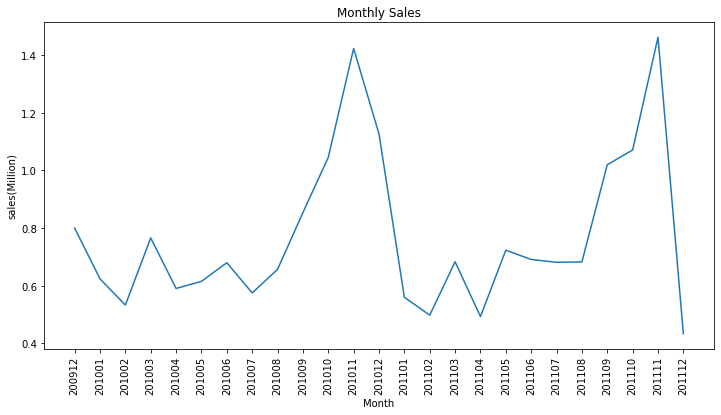

In [13]:
#add amount column in online_retail_df 
online_retail_df['InvoiceAmount'] = online_retail_df['Price'] * online_retail_df['Quantity']


monthly_sales = (
    online_retail_df
    .groupby('InvoiceYearMonth', as_index=False)['InvoiceAmount']
    .sum()
    .rename(columns={'InvoiceAmount': 'SalesAmount'})
)


monthly_sales['SalesMillion'] = monthly_sales['SalesAmount'] / 1000000

plt.figure(figsize=(12,6))
plt.plot(monthly_sales['InvoiceYearMonth'], monthly_sales['SalesMillion'])
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('sales(Million)')
plt.xticks(rotation=90)
plt.show()


# Monthly Sales Growth


- Calculate monthly sales percentage growth data: 

 Sales Growth % =((current month sales - prev month sales ) /prev month sales )) * 100 

- Plot a chart to show the growth percentage


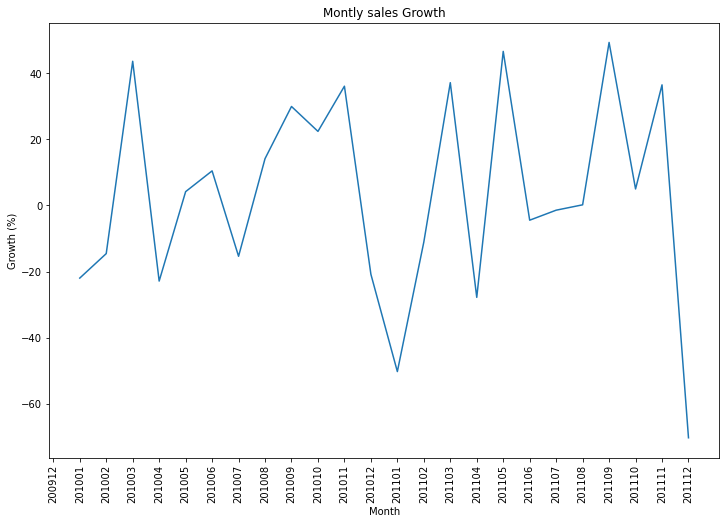

In [14]:
#pct_change() is a function that does the calculation automatically
monthly_sales['GrowthPerc'] = monthly_sales['SalesAmount'].pct_change()*100

plt.figure(figsize=(12,8))
plt.plot(monthly_sales['InvoiceYearMonth'], monthly_sales['GrowthPerc'])

plt.title('Montly sales Growth')
plt.xlabel('Month')
plt.ylabel('Growth (%)')
plt.xticks(rotation=90)
plt.show()


# Monthly Active Users

- Compute number of active users for each month
- Plot a bar chart

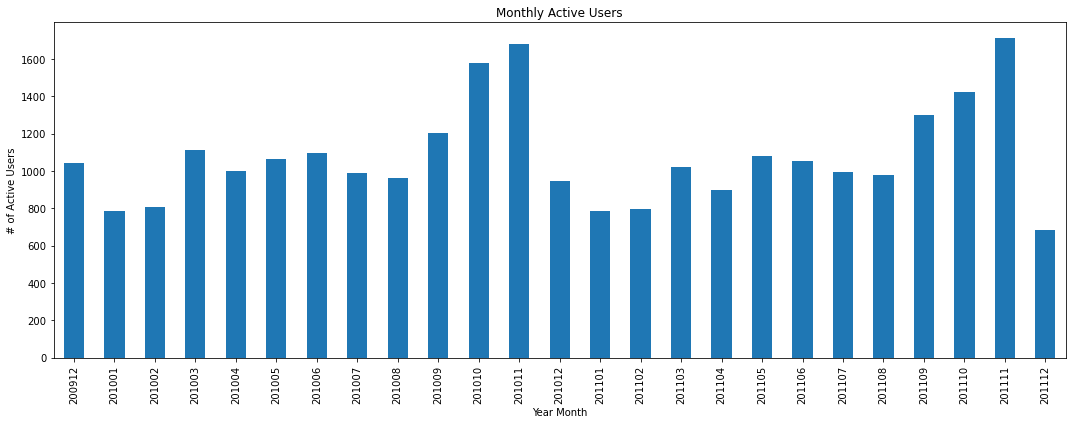

,InvoiceYearMonth,CustomerID
0,200912,1045
1,201001,786
2,201002,807
3,201003,1111
4,201004,998


In [15]:
monthly_active_users = (
    online_retail_df
    .groupby('InvoiceYearMonth', as_index=False)['CustomerID']
    .nunique()
)
ax = monthly_active_users.plot(
    x='InvoiceYearMonth',
    y='CustomerID',
    kind='bar',
    figsize=(15, 6),
    legend=False
)

ax.set_title("Monthly Active Users")
ax.set_xlabel("Year Month")
ax.set_ylabel("# of Active Users")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

monthly_active_users.head()


# New and Existing Users



- A user is identified as a new user when he/she makes the first purchase
- A user is identified as an existing user when he/she made purchases in the past


<AxesSubplot:xlabel='InvoiceYearMonth'>

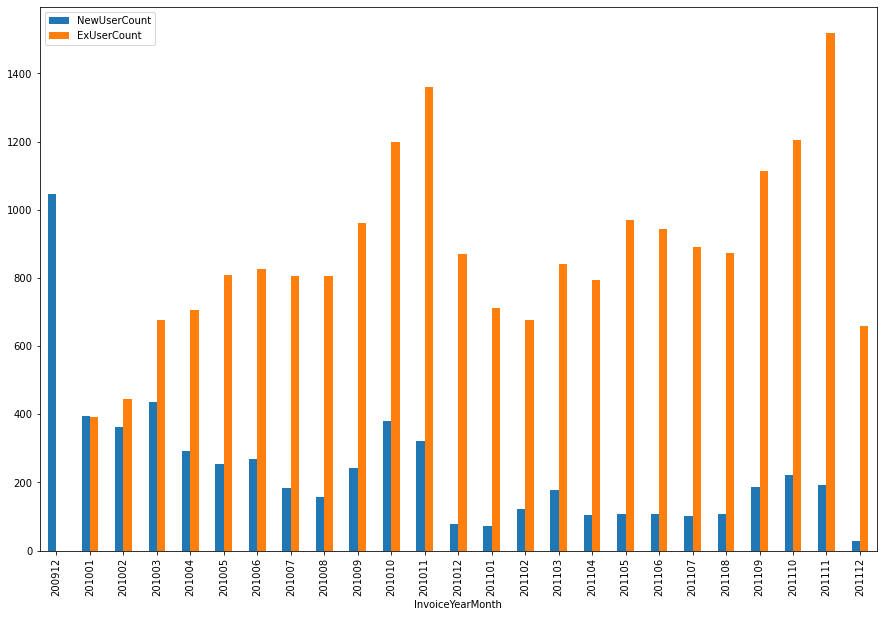

In [16]:
# First purchase month for each customer 
first_purchase = ( 
    online_retail_df
    .groupby('CustomerID')['InvoiceYearMonth']
    .min()
    .reset_index()
    .rename(columns={'InvoiceYearMonth':'FirstPurchaseMonth'})
)
first_purchase.head()

#Merge first purchase to online_retail_df
df = online_retail_df.merge(first_purchase, how='left', on='CustomerID')

#Classify each transaction as 'New' or 'Existing' user 
df['UserType'] = np.where(
    df['InvoiceYearMonth'] == df['FirstPurchaseMonth'],
    'New',
    'Existing'
)

#count new users per month
new_user_count = (
    df[df['UserType'] == 'New']
    .groupby('InvoiceYearMonth')['CustomerID']
    .nunique()
    .reset_index()
    .rename(columns={'CustomerID': 'NewUserCount'})
)

#count existing users per month
ex_user_count = (
    df[df['UserType'] == 'Existing']
    .groupby('InvoiceYearMonth')['CustomerID']
    .nunique()
    .reset_index()
    .rename(columns={'CustomerID': 'ExUserCount'})
)

#combine and plot
new_ex = pd.merge(new_user_count, ex_user_count, on="InvoiceYearMonth")
new_ex.plot(
    x="InvoiceYearMonth",
    y=["NewUserCount", "ExUserCount"],
    kind='bar',
    figsize=(15,10)
)

## Finding RFM

RFM stands for three dimensions:

- Recency: Time since customer last purchase

- Frequency: Total number of purchases

- Monetary Value: Total spending by the customer

In [17]:
# Use tofay's date as reference for recency
today = pd.to_datetime('today').normalize()

#Recency: days since last purchase
recency = online_retail_df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (today - recency['InvoiceDate']).dt.days

#only keep needed columns
recency = recency.drop(columns=['InvoiceDate'])

#Frequency: number of distinct invoices per customer
frequency = (
    online_retail_df
    .groupby('CustomerID')['Invoice']
    .nunique()
    .reset_index()
    .rename(columns={'Invoice': 'Frequency'})
)

#Monetary: total amount spent per customer
monetary = (
    online_retail_df
    .groupby('CustomerID')['InvoiceAmount']
    .sum()
    .reset_index()
    .rename(columns={'InvoiceAmount':'Monetary'})
)


#combine into RFM table
rfm_df = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')

rfm_df.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,5440,17,-64.68
1,12347.0,5117,8,5633.32
2,12348.0,5190,5,2019.40
3,12349.0,5133,5,4404.54
4,12350.0,5425,1,334.40


# RFM Segmentation


RFM segmentation categorizes customers based on Recency (how recently they purchased), Frequency (how often they buy), and Monetary (how much they spend), assigning each customer a 1-5 score for each metric.
These scores combine into a three-digit RFM score and are used to classify customers into segments such as Champions, Loyal Customers, Potential Loyalists, New Customers, At Risk, Hibernating, etc. But the key segments are can't lose, hibernating and champions


In [18]:
#RFM score values 
rfm_df['RecencyScore'] = pd.qcut(rfm_df['Recency'],5,labels=[5,4,3,2,1])
rfm_df['FrequencyScore'] = pd.qcut(rfm_df['Frequency'].rank(method="first"),5,labels=[1,2,3,4,5])
rfm_df['MonetaryScore'] = pd.qcut(rfm_df['Monetary'],5,labels=[1,2,3,4,5])

rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore
0,12346.0,5440,17,-64.68,2,5,1
1,12347.0,5117,8,5633.32,5,4,5
2,12348.0,5190,5,2019.40,3,3,4
3,12349.0,5133,5,4404.54,5,3,5
4,12350.0,5425,1,334.40,2,1,2


In [19]:
#Calculation of the RFM score
rfm_df["RFM_SCORE"] = rfm_df['RecencyScore'].astype(str) + rfm_df['FrequencyScore'].astype(str) + rfm_df['MonetaryScore'].astype(str)

In [20]:
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
0,12346.0,5440,17,-64.68,2,5,1,251
1,12347.0,5117,8,5633.32,5,4,5,545
2,12348.0,5190,5,2019.40,3,3,4,334
3,12349.0,5133,5,4404.54,5,3,5,535
4,12350.0,5425,1,334.40,2,1,2,212


In [21]:
#ex:customers withRFM_SCORE:223
rfm_df[rfm_df["RFM_SCORE"] == "223"].head()

,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
9,12355.0,5329,2,947.61,2,2,3,223
27,12373.0,5426,3,1127.65,2,2,3,223
40,12386.0,5452,2,660.80,2,2,3,223
159,12505.0,5416,3,908.00,2,2,3,223
234,12580.0,5361,2,1052.90,2,2,3,223


In [22]:
#segmenting of customers according to RecencyScore and FrequencyScore values
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

In [23]:
#creation of segment variable
rfm_df['Segment'] = rfm_df['RecencyScore'].astype(str) + rfm_df['FrequencyScore'].astype(str)
rfm_df['Segment'] = rfm_df['Segment'].replace(seg_map, regex=True)

In [24]:
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
0,12346.0,5440,17,-64.68,2,5,1,251,Can't Lose
1,12347.0,5117,8,5633.32,5,4,5,545,Champions
2,12348.0,5190,5,2019.40,3,3,4,334,Need Attention
3,12349.0,5133,5,4404.54,5,3,5,535,Potential Loyalists
4,12350.0,5425,1,334.40,2,1,2,212,Hibernating


In [25]:
rfm_df[["Segment", "Recency","Frequency","Monetary"]].groupby("Segment").agg(["mean","count"])

Recency        Frequency            Monetary      
                            mean count       mean count          mean count
Segment                                                                    
About to Sleep       5222.689474   380   1.460526   380    492.810900   380
At Risk              5491.094415   752   4.672872   752   1157.449162   752
Can't Lose           5436.305882    85  17.717647    85   5725.638494    85
Champions            5122.512850   856  23.532710   856  10510.937634   856
Hibernating          5580.237785  1535   1.336808  1535    340.030536  1535
Loyal Customers      5182.149565  1150  11.941739  1150   3966.024762  1150
Need Attention       5228.395604   273   3.673993   273   1099.877403   273
New Customers        5124.814815    54   1.000000    54    362.463148    54
Potential Loyalists  5139.674764   741   2.967611   741    899.359865   741
Promising            5152.758621   116   1.000000   116    322.758966   116

 # Bonus : Geographic market concentration & expansion opprtunity


In [26]:
country_customers = (
    online_retail_df.groupby('Country')['CustomerID']
    .nunique()
    .reset_index(name='UniqueCustomers')
)
country_customers['CountryGroup'] = country_customers['Country'].apply(
    lambda x: x if x == 'United Kingdom' else 'Other Countries'
)

grouped_countries = (
    country_customers.groupby('CountryGroup')['UniqueCustomers']
    .sum()
    .reset_index()
)

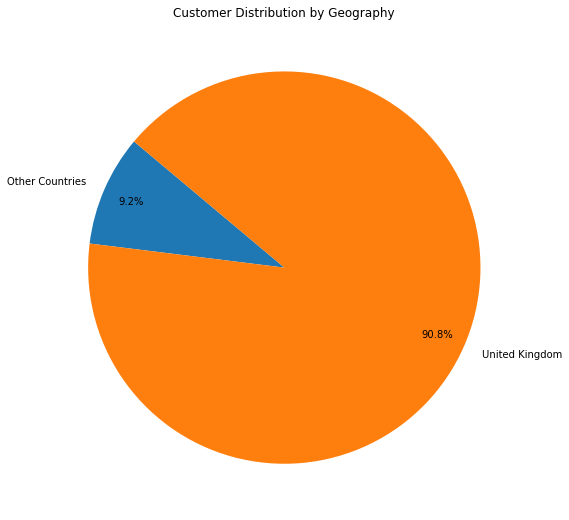

10 first other countries with the most customers


,Country,UniqueCustomers,Percentage
0,Germany,107,1.80
1,France,95,1.60
2,Spain,41,0.69
3,Belgium,29,0.49
4,Portugal,24,0.40
5,Netherlands,23,0.39
6,Switzerland,22,0.37
7,Sweden,19,0.32
8,Italy,17,0.29
9,Australia,15,0.25


In [27]:
# Plot pie chart

plt.figure(figsize=(8, 8))
plt.pie(
    grouped_countries['UniqueCustomers'],
    labels=grouped_countries['CountryGroup'],
    autopct='%1.1f%%',
    startangle=140,
    pctdistance=0.85,
)
plt.title("Customer Distribution by Geography")
plt.tight_layout()
plt.show()


# 4. Table for "Other Countries" with percentages

# Total unique customers 
total_customers = country_customers['UniqueCustomers'].sum()

other_countries = country_customers[country_customers['Country'] != 'United Kingdom'].copy()
other_countries['Percentage'] = (
    other_countries['UniqueCustomers'] / total_customers * 100
)

# Sort by percentage desc and round 
other_countries = (
    other_countries[['Country', 'UniqueCustomers', 'Percentage']]
    .sort_values('Percentage', ascending=False)
    .reset_index(drop=True)
)
other_countries['Percentage'] = other_countries['Percentage'].round(2)

print("10 first other countries with the most customers")
other_countries.head(10)
